# CHAPTER 2.7

### Using data augmentation to improve performance

We can synthesize new training examples by performing little modifications on the ones we already have, such as random rotations, random cropping, and horizontal flipping, among others. It is called data augmentation.

we'll use the Caltech 101 dataset, which is available here: http://www.vision.caltech.edu/Image_Datasets/Caltech101/.

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import *

In [2]:
SEED = 999
np.random.seed(SEED)

base_path = (pathlib.Path.home() / '.keras' / 'datasets' /
             '101_ObjectCategories')


In [3]:
base_path

WindowsPath('C:/Users/Zeki/.keras/datasets/101_ObjectCategories')

In [4]:
images_pattern = str(base_path / '*' / '*.jpg')
image_paths = [*glob(images_pattern)]


In [5]:
images_pattern

'C:\\Users\\Zeki\\.keras\\datasets\\101_ObjectCategories\\*\\*.jpg'

In [6]:
image_paths

['C:\\Users\\Zeki\\.keras\\datasets\\101_ObjectCategories\\accordion\\image_0001.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\101_ObjectCategories\\accordion\\image_0002.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\101_ObjectCategories\\accordion\\image_0003.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\101_ObjectCategories\\accordion\\image_0004.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\101_ObjectCategories\\accordion\\image_0005.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\101_ObjectCategories\\accordion\\image_0006.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\101_ObjectCategories\\accordion\\image_0007.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\101_ObjectCategories\\accordion\\image_0008.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\101_ObjectCategories\\accordion\\image_0009.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\101_ObjectCategories\\accordion\\image_0010.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\101_ObjectCategories\\accordion\\image_0011.jpg',
 'C:\\Users\\Zeki\\.keras\\datasets\\101_Ob

In [7]:
image_paths = [p for p in image_paths if
               p.split(os.path.sep)[-2] != 'BACKGROUND_Google']
classes = {p.split(os.path.sep)[-2] for p in image_paths}

In [9]:
classes

{'Faces',
 'Faces_easy',
 'Leopards',
 'Motorbikes',
 'accordion',
 'airplanes',
 'anchor',
 'ant',
 'barrel',
 'bass',
 'beaver',
 'binocular',
 'bonsai',
 'brain',
 'brontosaurus',
 'buddha',
 'butterfly',
 'camera',
 'cannon',
 'car_side',
 'ceiling_fan',
 'cellphone',
 'chair',
 'chandelier',
 'cougar_body',
 'cougar_face',
 'crab',
 'crayfish',
 'crocodile',
 'crocodile_head',
 'cup',
 'dalmatian',
 'dollar_bill',
 'dolphin',
 'dragonfly',
 'electric_guitar',
 'elephant',
 'emu',
 'euphonium',
 'ewer',
 'ferry',
 'flamingo',
 'flamingo_head',
 'garfield',
 'gerenuk',
 'gramophone',
 'grand_piano',
 'hawksbill',
 'headphone',
 'hedgehog',
 'helicopter',
 'ibis',
 'inline_skate',
 'joshua_tree',
 'kangaroo',
 'ketch',
 'lamp',
 'laptop',
 'llama',
 'lobster',
 'lotus',
 'mandolin',
 'mayfly',
 'menorah',
 'metronome',
 'minaret',
 'nautilus',
 'octopus',
 'okapi',
 'pagoda',
 'panda',
 'pigeon',
 'pizza',
 'platypus',
 'pyramid',
 'revolver',
 'rhino',
 'rooster',
 'saxophone',
 'sc

In [10]:
type(classes)

set

In [11]:
def load_images_and_labels(image_paths, target_size=(64, 64)):
    images = []
    labels = []

    for image_path in image_paths:
        image = load_img(image_path, target_size=target_size)
        image = img_to_array(image)

        label = image_path.split(os.path.sep)[-2]

        images.append(image)
        labels.append(label)

    return np.array(images), np.array(labels)

In [12]:
X, y = load_images_and_labels(image_paths)


In [14]:
X.shape

(8677, 64, 64, 3)

In [15]:
X = X.astype('float') / 255.0
y = LabelBinarizer().fit_transform(y)

In [17]:
y.shape

(8677, 101)

In [18]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y,test_size=0.2,random_state=SEED)

In [19]:
def build_network(width, height, depth, classes):
    input_layer = Input(shape=(width, height, depth))

    x = Conv2D(filters=32,
               kernel_size=(3, 3),
               padding='same')(input_layer)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters=32,
               kernel_size=(3, 3),
               padding='same')(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(rate=0.25)(x)

    x = Conv2D(filters=64,
               kernel_size=(3, 3),
               padding='same')(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters=64,
               kernel_size=(3, 3),
               padding='same')(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(rate=0.25)(x)

    x = Flatten()(x)
    x = Dense(units=512)(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Dropout(rate=0.25)(x)

    x = Dense(units=classes)(x)
    output = Softmax()(x)

    return Model(input_layer, output)

In [20]:
EPOCHS = 40
BATCH_SIZE = 64
model = build_network(64, 64, 3, len(classes))

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 re_lu (ReLU)                (None, 64, 64, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 re_lu_1 (ReLU)              (None, 64, 64, 32)        0         
                                                             

In [22]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [23]:
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE)

Epoch 1/40
109/109 [==============================] - 8s 41ms/step - loss: 2.5388 - accuracy: 0.4540 - val_loss: 5.8803 - val_accuracy: 0.0916
Epoch 2/40
109/109 [==============================] - 4s 34ms/step - loss: 1.2566 - accuracy: 0.6986 - val_loss: 4.2505 - val_accuracy: 0.1475
Epoch 3/40
109/109 [==============================] - 4s 36ms/step - loss: 0.5867 - accuracy: 0.8670 - val_loss: 2.8735 - val_accuracy: 0.3669
Epoch 4/40
109/109 [==============================] - 4s 34ms/step - loss: 0.2210 - accuracy: 0.9607 - val_loss: 2.1605 - val_accuracy: 0.5184
Epoch 5/40
109/109 [==============================] - 4s 35ms/step - loss: 0.1156 - accuracy: 0.9820 - val_loss: 1.7839 - val_accuracy: 0.6198
Epoch 6/40
109/109 [==============================] - 4s 36ms/step - loss: 0.0691 - accuracy: 0.9903 - val_loss: 1.8844 - val_accuracy: 0.5997
Epoch 7/40
109/109 [==============================] - 4s 36ms/step - loss: 0.0510 - accuracy: 0.9928 - val_loss: 1.8758 - val_accuracy: 0.6198

In [24]:
result = model.evaluate(X_test, y_test)
print(f'Test accuracy: {result[1]}')

55/55 [==============================] - 1s 7ms/step - loss: 2.2962 - accuracy: 0.6365
Test accuracy: 0.6365207433700562


In [25]:
def plot_model_history(model_history, metric, plot_name):
    plt.style.use('seaborn-darkgrid')
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({'Model': model_history}, metric=metric)

    plt.title(f'{metric.upper()}')
    plt.ylim([0, 1])

    plt.savefig(f'{plot_name}.png')
    plt.close()

In [26]:
plot_model_history(history, 'accuracy', 'normal')


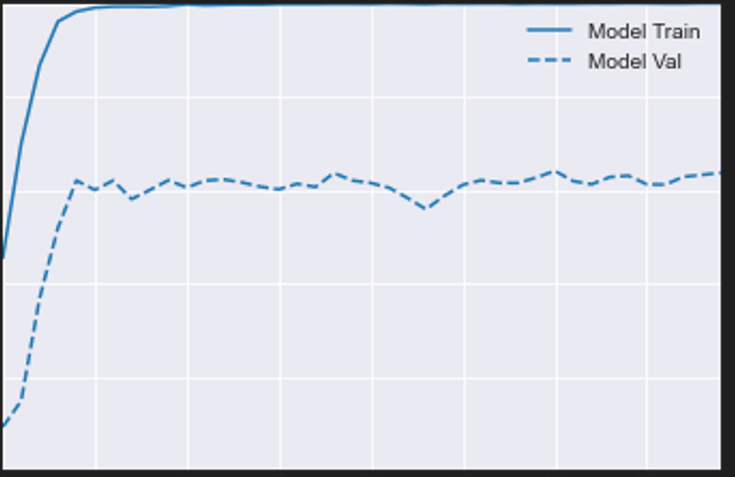

As you can see from plot or history data, training accuracy is high but test accuracy is really low. We will try augmentation to increase test accuracy

In [27]:
augmenter = ImageDataGenerator(horizontal_flip=True,
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.2,
                               zoom_range=0.2,
                               fill_mode='nearest')

In [28]:
train_generator = augmenter.flow(X_train, y_train, BATCH_SIZE)

In [29]:
train_generator

In [30]:
history = model.fit(train_generator,
                    steps_per_epoch=len(X_train) // BATCH_SIZE,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS)

Epoch 1/40
108/108 [==============================] - 8s 72ms/step - loss: 3.7179 - accuracy: 0.4368 - val_loss: 2.7836 - val_accuracy: 0.5639
Epoch 2/40
108/108 [==============================] - 7s 68ms/step - loss: 2.7073 - accuracy: 0.4847 - val_loss: 2.0451 - val_accuracy: 0.6406
Epoch 3/40
108/108 [==============================] - 8s 73ms/step - loss: 2.3085 - accuracy: 0.5252 - val_loss: 1.9479 - val_accuracy: 0.6227
Epoch 4/40
108/108 [==============================] - 8s 77ms/step - loss: 2.0267 - accuracy: 0.5611 - val_loss: 1.9590 - val_accuracy: 0.6215
Epoch 5/40
108/108 [==============================] - 9s 81ms/step - loss: 1.8918 - accuracy: 0.5694 - val_loss: 1.8357 - val_accuracy: 0.6273
Epoch 6/40
108/108 [==============================] - 8s 78ms/step - loss: 1.7665 - accuracy: 0.5844 - val_loss: 1.7346 - val_accuracy: 0.6400
Epoch 7/40
108/108 [==============================] - 9s 80ms/step - loss: 1.5947 - accuracy: 0.6148 - val_loss: 1.7566 - val_accuracy: 0.6325

In [31]:
result = model.evaluate(X_test, y_test)
print(f'Test accuracy: {result[1]}')

55/55 [==============================] - 1s 11ms/step - loss: 1.9395 - accuracy: 0.6371
Test accuracy: 0.6370967626571655


In [32]:
plot_model_history(history, 'accuracy', 'augmented')

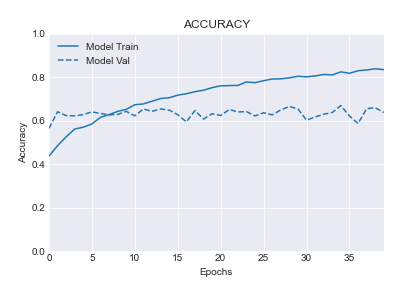

As you can see from model history, this time our training accuracy is increasing very slowly and the difference between training and test is less than normal.